<a href="https://colab.research.google.com/github/SarahAncheta/data102/blob/main/Data_102_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#@title set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/data102_final_project'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/data102_final_project'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import linear_model
import math
import io

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Datasets**

In [ ]:
%cd data102_final_project

/content/gdrive/My Drive/data102_final_project


In [ ]:
funding = pd.read_csv('candidate_summary_2018.csv')
funding

,Link_Image,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Cand_Party_Affiliation,Cand_Incumbent_Challenger_Open_Seat,Total_Receipt,Total_Disbursement,Cash_On_Hand_COP,Debt_Owed_By_Committee,Coverage_End_Date,Cand_Street_1,Cand_Street_2,Cand_City,Cand_State,Cand_Zip,Individual_Itemized_Contribution,Individual_Unitemized_Contribution,Individual_Contribution,Other_Committee_Contribution,Party_Committee_Contribution,Cand_Contribution,Total_Contribution,Transfer_From_Other_Auth_Committee,Cand_Loan,Other_Loan,Total_Loan,Offsets_To_Operating_Expenditure,Offsets_To_Fundraising,Offsets_To_Leagal_Accounting,Other_Receipts,Operating_Expenditure,Exempt_Legal_Accounting_Disbursement,Fundraising_Disbursement,Transfer_To_Other_Auth_Committee,Cand_Loan_Repayment,Other_Loan_Repayment,Total_Loan_Repayment,Individual_Refund,Party_Committee_Refund,Other_Committee_Refund,Total_Contribution_Refund,Other_Disbursements,Net_Contribution,Net_Operating_Expenditure,Cash_On_Hand_BOP,Debt_Owe_To_Committee,Coverage_Start_Date
0,https://www.fec.gov/data/candidate/H8TX05052/?...,"ASHBY, KEN",H8TX05052,H,TX,4.0,LIB,CHALLENGER,0.00,0.00,0.00,0.0,NaN,11837 LOCHWOOD BOULEVARD,NaN,DALLAS,TX,75218.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN
1,https://www.fec.gov/data/candidate/S6OH00288/?...,"ECKHART, DON ELIJAH",S6OH00288,S,OH,0.0,REP,CHALLENGER,0.00,0.00,0.00,0.0,NaN,",",NaN,",",OH,43119.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN
2,https://www.fec.gov/data/candidate/S8CA00499/?...,"ZIESING, MICHAEL VINCENT",S8CA00499,S,CA,0.0,GRE,CHALLENGER,0.00,0.00,0.00,0.0,NaN,1220 ALOHA ST,NaN,RED BLUFF,CA,96080.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN
3,https://www.fec.gov/data/candidate/H6NJ13191/?...,"SIRES, ALBIO",H6NJ13191,H,NJ,8.0,DEM,INCUMBENT,460108.57,596546.56,158849.09,0.0,12/31/2018,6050 BOULEVARD EAST,APT 6B,WEST NEW YORK,NJ,7093.0,161321.54,1848.84,163170.38,296686.67,0.00,0.00,459857.05,0.0,0.00,0.0,0.00,0.00,0,0,251.52,437542.51,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,500.0,500.0,98504.05,459357.05,437542.51,290287.08,0.0,01/01/2017
4,https://www.fec.gov/data/candidate/H6MI03172/?...,"SMITH, DOUGLAS MARK MR. JR.",H6MI03172,H,MI,3.0,IND,CHALLENGER,0.00,3873.60,0.00,0.0,12/31/2018,1410 SCOTT CREEK DR.,NaN,BELMONT,MI,49306.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0,0,0.00,3873.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,3873.60,3873.60,0.0,01/01/2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,https://www.fec.gov/data/candidate/H6OH04082/?...,"JORDAN, JAMES D.",H6OH04082,H,OH,4.0,REP,INCUMBENT,1241417.36,1809464.13,745640.94,0.0,12/31/2018,1709 SOUTH STATE ROUTE 560,NaN,URBANA,OH,43078.0,560189.00,350028.82,910217.82,306389.77,5000.00,0.00,1221607.59,0.0,0.00,0.0,0.00,72.15,0,0,19737.62,1599257.13,0.0,0.0,35000.0,0.0,0.0,0.0,11057.0,0.0,150.0,11207.0,164000.00,1210400.59,1599184.98,1313687.71,0.0,01/01/2017
3795,https://www.fec.gov/data/candidate/H8NY27176/?...,"MCMURRAY, NATHAN DOUGLAS",H8NY27176,H,NY,27.0,DEM,OPEN,1387653.64,1364110.33,23543.31,0.0,12/31/2018,1041 FOXCROFT,NaN,GRAND ISLAND,NY,14072.0,629591.23,527391.94,1156983.17,151065.00,48163.31,1900.00,1358111.48,0.0,18000.00,0.0,18000.00,587.75,0,0,10954.41,1342096.72,0.0,0.0,0.0,18000.0,0.0,18000.0,3252.5,0.0,0.0,3252.5,761.11,1354858.98,1341508.97,0.00,0.0,01/01/2018
3796,https://www.fec.gov/data/candidate/H8IN06152/?...,"LAKE, JEANNINE LEE",H8IN06152,H,IN,6.0,DEM,OPEN,100644.90,101754.84,50.58,0.0,12/31/2018,5300 NORTH CO. ROAD 500 WEST,NaN,MUNICE,IN,47304.0,37970.87,51484.23,89455.10,3415.29,370.04,898.27,94

In [ ]:
rep = pd.read_csv('rep_candidates.csv', encoding='cp1252')
rep

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Primary %,Won Primary,Rep Party Support?,Trump Endorsed?,Bannon Endorsed?,Great America Endorsed?,NRA Endorsed?,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?
0,Mike Dunleavy,AK,Governor of Alaska,Governor,Regular,8/21/18,Advanced,None,On the Ballot,61.8,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Michael Sheldon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,None,None,2.2,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mead Treadwell,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,None,None,31.9,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Darin Colbry,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,None,None,0.6,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thomas Gordon,AK,Governor of Alaska,Governor,Regular,8/21/18,Lost,None,None,1.3,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,Bill Dahlin,WY,Governor of Wyoming,Governor,Regular,8/21/18,Lost,None,None,1.5,No,NaN,No,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,Harriet Hageman,WY,Governor of Wyoming,Governor,Regular,8/21/18,Lost,None,None,21.5,No,NaN,No,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
771,Sam Galeotos,WY,Governor of Wyoming,Governor,Regular,8/21/18,Lost,None,None,12.5,No,NaN,No,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772,Foster Friess,WY,Governor of Wyoming,Governor,Regular,8/21/18,Lost,None,None,25.6,No,NaN,Yes,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dem = pd.read_csv('dem_candidates.csv', encoding='cp1252')
dem

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,Primary %,Won Primary,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?,Party Support?,Emily Endorsed?,Guns Sense Candidate?,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,3.420000,No,Nonwhite,Yes,No,No,No,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,1.740000,No,White,No,Yes,No,No,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,3.270000,No,White,Yes,No,No,No,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,8.000000,No,Nonwhite,Yes,No,Yes,No,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,28.980000,No,White,No,No,Yes,No,No,No,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,Talley Sergent,WV,U.S. House West Virginia District 2,Representative,Regular,5/8/18,Advanced,None,On the Ballot,-35.330002,62.570000,Yes,White,No,No,No,No,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
807,Janice Hagerman,WV,U.S. House West Virginia District 3,Representative,Regular,5/8/18,Lost,None,None,-47.480000,7.240000,No,White,No,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN
808,Paul Davis,WV,U.S. House West Virginia District 3,Representative,Regular,5/8/18,Lost,None,None,-47.480000,15.960000,No,White,No,No,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN
809,Richard Ojeda,WV,U.S. House West Virginia District 3,Representative,Regular,5/8/18,Advanced,None,On the Ballot,-47.480000,52.160000,Yes,Nonwhite,Yes,No,Yes,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes,NaN


### **Question 1 (Bayesian Inference)**

Question 1 (Bayesian Inference): Can we predict whether an individual running for Senate is trying to take a position that is currently open, filled, or filled by the individual in question based solely off of funding and net expenditure? 

In [ ]:
#Cleaning dataset
#Removing all irrelevant columns
funding = funding.fillna(method='ffill')
cleaned = funding[['Cand_Incumbent_Challenger_Open_Seat', 'Total_Contribution', 'Operating_Expenditure']]
cleaned.head()
#binarizing Challenger, Incumbent, Open as 1, 2, 3 respectively
cleaned.loc[cleaned['Cand_Incumbent_Challenger_Open_Seat'] == 'CHALLENGER', 'Cand_Incumbent_Challenger_Open_Seat'] = 1
cleaned.loc[cleaned['Cand_Incumbent_Challenger_Open_Seat'] == 'INCUMBENT', 'Cand_Incumbent_Challenger_Open_Seat'] = 2
cleaned.loc[cleaned['Cand_Incumbent_Challenger_Open_Seat'] == 'OPEN', 'Cand_Incumbent_Challenger_Open_Seat'] = 3
cleaned.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,Cand_Incumbent_Challenger_Open_Seat,Total_Contribution,Operating_Expenditure
0,1,0.00,0.00
1,1,0.00,0.00
2,1,0.00,0.00
3,2,459857.05,437542.51
4,1,0.00,3873.60


In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X = cleaned[['Total_Contribution','Operating_Expenditure']].to_numpy()
y = cleaned['Cand_Incumbent_Challenger_Open_Seat'].to_numpy()
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109) # 70% training and 30% test

#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.28596491228070176


In [ ]:
#Cleaning dataset
#Removing all irrelevant columns
funding = funding.fillna(method='ffill')
cleaned = funding[['Cand_Incumbent_Challenger_Open_Seat', 'Total_Contribution', 'Operating_Expenditure']]
cleaned.head()
#dropping all candidates that have a Total_Contribution or Operating_Expenditure of 0
#we are only looking to see if strength of contribution can predict a seat filled, open, or filled by candidate in question
cleaned = cleaned.loc[~((cleaned['Total_Contribution'] == 0))]
cleaned = cleaned.loc[~((cleaned['Operating_Expenditure'] == 0))]
#binarizing Challenger, Incumbent, Open as 1, 2, 3 respectively
cleaned.loc[cleaned['Cand_Incumbent_Challenger_Open_Seat'] == 'CHALLENGER', 'Cand_Incumbent_Challenger_Open_Seat'] = 1
cleaned.loc[cleaned['Cand_Incumbent_Challenger_Open_Seat'] == 'INCUMBENT', 'Cand_Incumbent_Challenger_Open_Seat'] = 2
cleaned.loc[cleaned['Cand_Incumbent_Challenger_Open_Seat'] == 'OPEN', 'Cand_Incumbent_Challenger_Open_Seat'] = 3
cleaned.head()

,Cand_Incumbent_Challenger_Open_Seat,Total_Contribution,Operating_Expenditure
3,2,459857.05,437542.51
6,1,4365.06,7357.50
7,1,20583.09,19670.32
8,3,3547064.51,3946213.62
9,1,10258.00,14448.81


In [ ]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X = cleaned[['Total_Contribution','Operating_Expenditure']].to_numpy()
y = cleaned['Cand_Incumbent_Challenger_Open_Seat'].to_numpy()
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109) # 70% training and 30% test

#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2991573033707865


In [ ]:
#Cleaning dataset
#Removing all irrelevant columns
funding = funding.fillna(method='ffill')
cleaned = funding[['Cand_Incumbent_Challenger_Open_Seat', 'Total_Contribution', 'Operating_Expenditure', 'Individual_Itemized_Contribution', 'Individual_Unitemized_Contribution', 'Individual_Contribution', 'Other_Committee_Contribution', 'Party_Committee_Contribution', 'Cand_Contribution']]
cleaned.head()
#dropping all candidates that have a Total_Contribution or Operating_Expenditure of 0
#we are only looking to see if strength of contribution can predict a seat filled, open, or filled by candidate in question
cleaned = cleaned.loc[~((cleaned['Total_Contribution'] == 0))]
cleaned = cleaned.loc[~((cleaned['Operating_Expenditure'] == 0))]
#binarizing Challenger, Incumbent, Open as 1, 2, 3 respectively
cleaned.loc[cleaned['Cand_Incumbent_Challenger_Open_Seat'] == 'CHALLENGER', 'Cand_Incumbent_Challenger_Open_Seat'] = 1
cleaned.loc[cleaned['Cand_Incumbent_Challenger_Open_Seat'] == 'INCUMBENT', 'Cand_Incumbent_Challenger_Open_Seat'] = 2
cleaned.loc[cleaned['Cand_Incumbent_Challenger_Open_Seat'] == 'OPEN', 'Cand_Incumbent_Challenger_Open_Seat'] = 3
cleaned.head()

,Cand_Incumbent_Challenger_Open_Seat,Total_Contribution,Operating_Expenditure,Individual_Itemized_Contribution,Individual_Unitemized_Contribution,Individual_Contribution,Other_Committee_Contribution,Party_Committee_Contribution,Cand_Contribution
3,2,459857.05,437542.51,161321.54,1848.84,163170.38,296686.67,0.0,0.0
6,1,4365.06,7357.50,481.21,3883.85,4365.06,0.00,0.0,0.0
7,1,20583.09,19670.32,8831.10,10735.39,19566.49,200.00,0.0,816.6
8,3,3547064.51,3946213.62,2311197.01,672129.40,2983326.41,550232.50,5150.0,8355.6
9,1,10258.00,14448.81,6425.00,3658.00,10083.00,0.00,0.0,175.0


In [ ]:

# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X = cleaned[['Total_Contribution', 'Operating_Expenditure', 'Individual_Itemized_Contribution', 'Individual_Unitemized_Contribution', 'Individual_Contribution', 'Other_Committee_Contribution', 'Party_Committee_Contribution', 'Cand_Contribution']].to_numpy()
y = cleaned['Cand_Incumbent_Challenger_Open_Seat'].to_numpy()
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109) # 70% training and 30% test

#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4058988764044944


### **Question 2 (Causal Inference)**

Question 2 (Causal Inference): How do endorsements effect who you vote for? What endorsements have more weight than others?


In [ ]:
#data cleaning
dem['Primary Status'] = dem['Primary Status'].replace('Lost',0).replace('Advanced',1) # outcome of election
dem = dem.replace('Yes',1).replace('No',0).fillna(0)

In [ ]:
rep['Primary Status'] = rep['Primary Status'].replace('Lost',0).replace('Advanced',1).replace('On the Ballot',1) # outcome of election
rep = rep.replace('Yes',1).replace('No',0).fillna(0)

In [ ]:
Y = dem['Primary Status'].dropna()
Z = dem.iloc[:,19:32] #all endorsements
Z = sm.add_constant(Z)

model = sm.OLS(Y,Z)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Primary Status   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     11.77
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.39e-23
Time:                        04:18:22   Log-Likelihood:                -465.55
No. Observations:                 811   AIC:                             959.1
Df Residuals:                     797   BIC:                             1025.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.2311      0.019     12.345      0.000       0.194       0.268
Party Support?               0.4680      0.085      5.479      0.000       0.300       0.636
Emily Endorsed?              0.2230      0.067      3.307      0.001       0.091       0.355
Guns Sense Candidate?        0.0969      0.037      2.632      0.009       0.025       0.169
Biden Endorsed?              0.2463      0.151      1.627      0.104      -0.051       0.543
Warren Endorsed?             0.3149      0.207      1.523      0.128      -0.091       0.721
Sanders Endorsed?            0.1430      0.162      0.885      0.377      -0.174       0.460
Our Revolution Endorsed?    -0.0023      0.056     -0.042      0.967      -0.113       0.109
Justice Dems Endorsed?       0.0689      0.071      0.976      0.329      -0.070       0.208
PCCC Endorsed?              -0.0032      0.130     -0.025      0.980      -0.259       0.253
Indivisible Endorsed?        0.3370      0.067      4.993      0.000       0.204       0.469
WFP Endorsed?                0.1603      0.087      1.846      0.065      -0.010       0.331
VoteVets Endorsed?           0.0084      0.089      0.093      0.926      -0.167       0.184
No Labels Support?          -0.2353      0.310     -0.759      0.448      -0.844       0.373
==============================================================================
Omnibus:                      143.721   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.923
Skew:                           0.856   Prob(JB):                     5.52e-27
Kurtosis:                       2.196   Cond. No.                         21.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Y = rep['Primary Status'].dropna()
Z = rep.iloc[:,11:25] #all endorsements
Z = sm.add_constant(Z)

model = sm.OLS(Y,Z)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Primary Status   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     5.740
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.02e-10
Time:                        04:18:22   Log-Likelihood:                -477.24
No. Observations:                 774   AIC:                             984.5
Df Residuals:                     759   BIC:                             1054.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.2781      0.018     15.424      0.000       0.243       0.313
Rep Party Support?             0.2329      0.064      3.662      0.000       0.108       0.358
Trump Endorsed?                0.3135      0.135      2.328      0.020       0.049       0.578
Bannon Endorsed?               0.1512      0.276      0.548      0.584      -0.391       0.693
Great America Endorsed?       -0.1060      0.292     -0.363      0.717      -0.679       0.467
NRA Endorsed?                  0.2214      0.128      1.730      0.084      -0.030       0.473
Right to Life Endorsed?        0.0449      0.058      0.774      0.439      -0.069       0.159
Susan B. Anthony Endorsed?     0.0056      0.104      0.054      0.957      -0.198       0.209
Club for Growth Endorsed?      0.0959      0.132      0.724      0.469      -0.164       0.356
Koch Support?                  0.3452      0.117      2.951      0.003       0.116       0.575
House Freedom Support?        -0.0097      0.147     -0.066      0.947      -0.299       0.279
Tea Party Endorsed?            0.1943      0.129      1.511      0.131      -0.058       0.447
Main Street Endorsed?          0.1711      0.115      1.486      0.138      -0.055       0.397
Chamber Endorsed?              0.0501      0.171      0.294      0.769      -0.285       0.385
No Labels Support?             0.1055      0.322      0.328      0.743      -0.526       0.737
==============================================================================
Omnibus:                      421.964   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.821
Skew:                           0.787   Prob(JB):                     3.52e-27
Kurtosis:                       1.860   Cond. No.                         23.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Naive Estimator

In [ ]:
# ATE for dem
endorsements = dem[['Party Support?',
            'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Emily Endorsed?',
 'Guns Sense Candidate?',
 'Indivisible Endorsed?',]]

# endorsements = dem[['Party Support?',
#  'Biden Endorsed?',
#  'Warren Endorsed? ',
#  'Sanders Endorsed?',]]

# endorsements = dem[['Party Support?']]

not_endorsed = endorsements[endorsements.sum(axis=1) == 0]

control = dem.loc[not_endorsed.index] 
treat = dem.loc[~dem.index.isin(control.index)]

treatment = pd.Series(np.zeros(len(dem))).rename('treatment')
treatment.loc[treat.index] = 1
dem['treatment'] = treatment #treatment 1 = endorsed by any candidate

ATE = np.mean(treat['Primary Status']) - np.mean(control['Primary Status'])
ATE

0.31374077395323174

In [ ]:
len(control), len(treat)

(772, 39)

In [ ]:
import statsmodels.api as sm
Y = dem['Primary Status'].dropna()
Z = dem['treatment'].dropna()
Z = sm.add_constant(Z)

model = sm.OLS(Y,Z)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Primary Status   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     78.87
Date:                Tue, 11 May 2021   Prob (F-statistic):           4.22e-18
Time:                        04:18:22   Log-Likelihood:                -499.03
No. Observations:                 811   AIC:                             1002.
Df Residuals:                     809   BIC:                             1011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2953      0.016     18.306      0.000       0.264       0.327
treatment      0.6534      0.074      8.881      0.000       0.509       0.798
==============================================================================
Omnibus:                      371.518   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.460
Skew:                           0.880   Prob(JB):                     2.59e-32
Kurtosis:                       1.902   Cond. No.                         4.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# ATE for rep
endorsements = rep[['Rep Party Support?']]
#  'Trump Endorsed?',
#  'Koch Support?',
#  'NRA Endorsed?',]]

not_endorsed = endorsements[endorsements.sum(axis=1) == 0]

control = rep.loc[not_endorsed.index] 
treat = rep.loc[~rep.index.isin(control.index)]

treatment = pd.Series(np.zeros(len(rep))).rename('treatment')
treatment.loc[treat.index] = 1
rep['treatment'] = treatment #treatment 1 = endorsed by any candidate

ATE = np.mean(treat['Primary Status']) - np.mean(control['Primary Status'])
ATE

0.31103074141048825

In [ ]:
Y = rep['Primary Status'].dropna()
Z = rep['treatment'].dropna()
Z = sm.add_constant(Z)

model = sm.OLS(Y,Z)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Primary Status   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     64.74
Date:                Tue, 11 May 2021   Prob (F-statistic):           3.21e-15
Time:                        04:18:22   Log-Likelihood:                -485.01
No. Observations:                 774   AIC:                             974.0
Df Residuals:                     772   BIC:                             983.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2849      0.017     16.397      0.000       0.251       0.319
treatment      0.4033      0.050      8.046      0.000       0.305       0.502
==============================================================================
Omnibus:                      378.098   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.733
Skew:                           0.726   Prob(JB):                     2.45e-24
Kurtosis:                       1.877   Cond. No.                         3.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### With Confounder


In [ ]:
# dem
X = (dem[['Obama Alum?','Partisan Lean']].replace("Yes",1).replace("No",0)).dropna()
Z = dem['treatment'].loc[X.index]
Y = dem['Primary Status'].loc[X.index]

Y = Y.to_numpy()
X = X.to_numpy()
Z = Z.to_numpy()

from sklearn.linear_model import LogisticRegression as LR
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X,Z)

def estimate_treatment_effect(fit,X,Y,Z):
  e_x = fit.predict_proba(X)[:,1]
  ATE = np.mean((Z*Y)/e_x - (1-Z)*Y/(1-e_x))
  return ATE

estimate_treatment_effect(fit,X,Y,Z)

0.3341156228498388

In [ ]:
Y = dem['Primary Status'].dropna()
Z = dem['treatment'].dropna()

n_1 = np.sum(Z)
n_0 = len(Z) - n_1
ATE = np.sum(Y*Z)/n_1 - np.sum(Y*(1-Z))/n_0
ATE

0.6533811611531819

In [ ]:
Y = dem['Primary Status'].dropna()
Z = dem[['Obama Alum?','Partisan Lean','treatment']].dropna()
# Z['Partisan Lean'] = stats.zscore(dem['Partisan Lean'])
Z = sm.add_constant(Z)

model = sm.OLS(Y,Z)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Primary Status   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     43.62
Date:                Tue, 11 May 2021   Prob (F-statistic):           3.97e-26
Time:                        04:18:22   Log-Likelihood:                -475.82
No. Observations:                 811   AIC:                             959.6
Df Residuals:                     807   BIC:                             978.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2200      0.019     11.431      0.000       0.182       0.258
Obama Alum?       0.1049      0.077      1.359      0.174      -0.047       0.256
Partisan Lean    -0.0051      0.001     -6.874      0.000      -0.007      -0.004
treatment         0.6907      0.072      9.595      0.000       0.549       0.832
==============================================================================
Omnibus:                      218.966   Durbin-Watson:                   2.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.854
Skew:                           0.811   Prob(JB):                     5.71e-27
Kurtosis:                       2.028   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# rep 
X = (dem[['Obama Alum?','Partisan Lean']].replace("Yes",1).replace("No",0)).dropna()
Z = dem['treatment'].loc[X.index]
Y = dem['Primary Status'].loc[X.index]

Y = Y.to_numpy()
X = X.to_numpy()
Z = Z.to_numpy()

from sklearn.linear_model import LogisticRegression as LR
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X,Z)

def estimate_treatment_effect(fit,X,Y,Z):
  e_x = fit.predict_proba(X)[:,1]
  ATE = np.mean((Z*Y)/e_x - (1-Z)*Y/(1-e_x))
  return ATE

estimate_treatment_effect(fit,X,Y,Z)

0.5942179239558727

### Simpsons Paradox

In [ ]:
# merging dem and rep
df = rep[['Rep Party Support?','Primary Status']]
df.columns = ['Party Support?','Primary Status']
df['party'] = ['rep']*len(df)
df2 = dem[['Party Support?','Primary Status']]
df2['party'] = ['dem']*len(df2)
all_candidates = pd.concat([df,df2])

d = {'Party Support (Treatment)': [39/63,37/39,76/102], 'No Party Support (Control)': [219/711,228/772,447/1483]}
pd.DataFrame(d,index=['Rep','Dem','Total'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Party Support (Treatment),No Party Support (Control)
Rep,0.619048,0.308017
Dem,0.948718,0.295337
Total,0.745098,0.301416


In [ ]:
len(all_candidates[(all_candidates['Party Support?'] == 0) & 
              #  (all_candidates['Primary Status'] == 1) & 
               (all_candidates['party'] == 'dem')])

772

In [ ]:
len(all_candidates)

1585

### **Question 2 (GLM and Nonparametric)**



### GLM

In [ ]:
list(dem)

['Candidate',
 'State',
 'District',
 'Office Type',
 'Race Type',
 'Race Primary Election Date',
 'Primary Status',
 'Primary Runoff Status',
 'General Status',
 'Partisan Lean',
 'Primary %',
 'Won Primary',
 'Race',
 'Veteran?',
 'LGBTQ?',
 'Elected Official?',
 'Self-Funder?',
 'STEM?',
 'Obama Alum?',
 'Party Support?',
 'Emily Endorsed?',
 'Guns Sense Candidate?',
 'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'Indivisible Endorsed?',
 'WFP Endorsed?',
 'VoteVets Endorsed?',
 'No Labels Support?',
 'treatment']

In [ ]:
##Cleaning data sets, choosing endorsements, primary status, and candidate, then replacing string values as specified above
dem_clean = dem[['Candidate', 'Primary Status', 'Emily Endorsed?',
 'Guns Sense Candidate?',
 'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'Indivisible Endorsed?',
 'WFP Endorsed?',
 'VoteVets Endorsed?',
 'No Labels Support?' ]]
dem_clean = dem_clean.fillna(0)
dem_clean_binary = dem_clean.replace(['Advanced', 'Lost', 'Yes', 'No'], [1, 0, 1, -1])

In [ ]:
list(rep)

['Candidate',
 'State',
 'District',
 'Office Type',
 'Race Type',
 'Race Primary Election Date',
 'Primary Status',
 'Primary Runoff Status',
 'General Status',
 'Primary %',
 'Won Primary',
 'Rep Party Support?',
 'Trump Endorsed?',
 'Bannon Endorsed?',
 'Great America Endorsed?',
 'NRA Endorsed?',
 'Right to Life Endorsed?',
 'Susan B. Anthony Endorsed?',
 'Club for Growth Endorsed?',
 'Koch Support?',
 'House Freedom Support?',
 'Tea Party Endorsed?',
 'Main Street Endorsed?',
 'Chamber Endorsed?',
 'No Labels Support?',
 'treatment']

In [ ]:
rep['Primary Status'].unique()

array([1, 0])

In [ ]:
rep_clean = rep[['Candidate','Primary Status','Rep Party Support?',
 'Trump Endorsed?',
 'Bannon Endorsed?',
 'Great America Endorsed?',
 'NRA Endorsed?',
 'Right to Life Endorsed?',
 'Susan B. Anthony Endorsed?',
 'Club for Growth Endorsed?',
 'Koch Support?',
 'House Freedom Support?',
 'Tea Party Endorsed?',
 'Main Street Endorsed?',
 'Chamber Endorsed?',
 'No Labels Support?']]

In [ ]:
 rep_clean = rep_clean.fillna(0)
 rep_clean_binary = rep_clean.replace(['Advanced', 'On the Ballot', 'Lost', 'Yes', 'No'], [1, 1, 0, 1, -1])

In [ ]:
#Split into y, predicting primary status, and x, different endorsements for both data sets

In [ ]:
y_dem = dem_clean_binary[['Primary Status']]
X_dem = dem_clean_binary[['Emily Endorsed?',
 'Guns Sense Candidate?',
 'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'Indivisible Endorsed?',
 'WFP Endorsed?',
 'VoteVets Endorsed?',
 'No Labels Support?' ]]

y_rep = rep_clean_binary[['Primary Status']]
X_rep = rep_clean_binary[['Rep Party Support?',
 'Trump Endorsed?',
 'Bannon Endorsed?',
 'Great America Endorsed?',
 'NRA Endorsed?',
 'Right to Life Endorsed?',
 'Susan B. Anthony Endorsed?',
 'Club for Growth Endorsed?',
 'Koch Support?',
 'House Freedom Support?',
 'Tea Party Endorsed?',
 'Main Street Endorsed?',
 'Chamber Endorsed?',
 'No Labels Support?']]

In [ ]:
Xdem_train, Xdem_test, ydem_train, ydem_test = train_test_split(
    X_dem, y_dem, test_size=80, random_state=42
)

In [ ]:
Xrep_train, Xrep_test, yrep_train, yrep_test = train_test_split(
    X_rep, y_rep, test_size=75, random_state=42
)

In [ ]:
dem_log_reg = sm.Logit(ydem_train, Xdem_train).fit()
print(dem_log_reg.summary())

         Current function value: 0.664898
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         Primary Status   No. Observations:                  731
Model:                          Logit   Df Residuals:                      719
Method:                           MLE   Df Model:                           11
Date:                Tue, 11 May 2021   Pseudo R-squ.:                -0.06228
Time:                        04:18:23   Log-Likelihood:                -486.04
converged:                      False   LL-Null:                       -457.55
Covariance Type:            nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Emily Endorsed?              0.7416      0.357      2.076      0.038       0.041       1.442
Guns Sense Candidate?  

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
dem_yhat = dem_log_reg.predict(Xdem_test)
dem_prediction = list(map(round, dem_yhat))
print('Test accuracy = ', accuracy_score(ydem_test, dem_prediction))

Test accuracy =  0.7125


In [ ]:
rep_log_reg = sm.Logit(yrep_train, Xrep_train).fit()
print(rep_log_reg.summary())

         Current function value: 0.667434
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         Primary Status   No. Observations:                  699
Model:                          Logit   Df Residuals:                      685
Method:                           MLE   Df Model:                           13
Date:                Tue, 11 May 2021   Pseudo R-squ.:                -0.04535
Time:                        04:18:23   Log-Likelihood:                -466.54
converged:                      False   LL-Null:                       -446.30
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Rep Party Support?             0.2619      0.316      0.830      0.407      -0.357       0.881
Trump Endorsed?  

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
rep_yhat = rep_log_reg.predict(Xrep_test)
rep_prediction = list(map(round, rep_yhat))
print('Test accuracy = ', accuracy_score(yrep_test, rep_prediction))

Test accuracy =  0.7066666666666667


### Nonparametric

Random Forest Model, depth 6

In [ ]:
dem_tree_model = RandomForestClassifier(n_estimators=100, max_depth=6)
dem_tree_model.fit(Xdem_train, ydem_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
dem_probs = dem_tree_model.predict_proba(Xdem_test)[:, 1]
demTree_prediction = dem_probs > 0.5


In [ ]:
print("Accuracy", (demTree_prediction == ydem_test['Primary Status']).mean())

Accuracy 0.6625


In [ ]:
rep_tree_model = RandomForestClassifier(n_estimators=100, max_depth=6)
rep_tree_model.fit(Xrep_train, yrep_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rep_probs = rep_tree_model.predict_proba(Xrep_test)[:, 1]
repTree_prediction = rep_probs > 0.5
print("Accuracy", (repTree_prediction == yrep_test['Primary Status']).mean())

Accuracy 0.7333333333333333


### **EDA for Question 2**

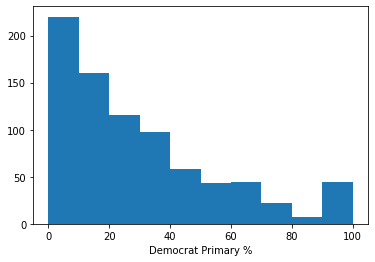

In [ ]:
plt.hist(dem['Primary %'])
plt.xlabel('Democrat Primary %')
plt.show()

In [ ]:
# assuming a multivariate Gaussian distribution
mean = [0, 0]
cov = [[1, 1], [1, 2]]
x, y = np.random.multivariate_normal(mean, cov, 10000).T

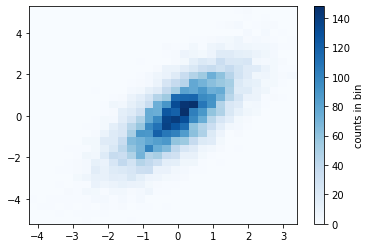

In [ ]:
plt.hist2d(x, y, bins=30, cmap='Blues')
cb = plt.colorbar()
cb.set_label('counts in bin')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


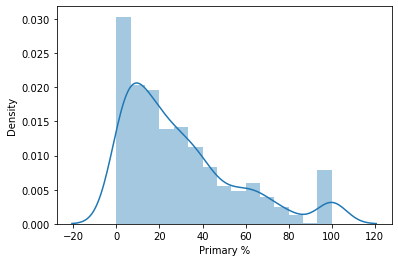

In [ ]:
sns.distplot(dem['Primary %'])

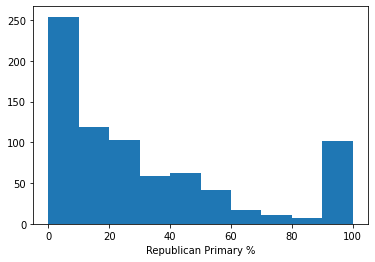

In [ ]:
plt.hist(rep['Primary %'])
plt.xlabel('Republican Primary %')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


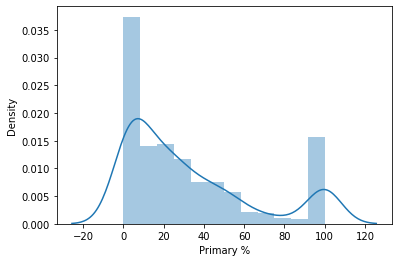

In [ ]:
sns.distplot(rep['Primary %'])

In [ ]:
# 0.0 is No and 1.0 is Yes
dem['Biden Endorsed?'].value_counts()

0.0    801
1.0     10
Name: Biden Endorsed?, dtype: int64

In [ ]:
# 0.0 is No and 1.0 is Yes
dem['Sanders Endorsed?'].value_counts()

0.0    802
1.0      9
Name: Sanders Endorsed?, dtype: int64

In [ ]:
rep['Trump Endorsed?']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
769    0.0
770    0.0
771    0.0
772    1.0
773    0.0
Name: Trump Endorsed?, Length: 774, dtype: float64

In [ ]:
rep['Bannon Endorsed?'].value_counts()

0.0    766
1.0      8
Name: Bannon Endorsed?, dtype: int64

In [ ]:
# 0.0 is No and 1.0 is Yes
dem['Won Primary'].value_counts()

0.0    572
1.0    239
Name: Won Primary, dtype: int64

In [ ]:
rep['Won Primary'].value_counts()

0    529
1    245
Name: Won Primary, dtype: int64

In [ ]:
dem['Self-Funder?'].value_counts()

0    768
1     43
Name: Self-Funder?, dtype: int64

In [ ]:
rep['House Freedom Support?'].value_counts()

0.0    760
1.0     14
Name: House Freedom Support?, dtype: int64

### **EDA for Question 1**

In [ ]:
data_summary = pd.read_csv('candidate_summary_2018.csv')
data_summary

,Link_Image,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Cand_Party_Affiliation,Cand_Incumbent_Challenger_Open_Seat,Total_Receipt,Total_Disbursement,Cash_On_Hand_COP,Debt_Owed_By_Committee,Coverage_End_Date,Cand_Street_1,Cand_Street_2,Cand_City,Cand_State,Cand_Zip,Individual_Itemized_Contribution,Individual_Unitemized_Contribution,Individual_Contribution,Other_Committee_Contribution,Party_Committee_Contribution,Cand_Contribution,Total_Contribution,Transfer_From_Other_Auth_Committee,Cand_Loan,Other_Loan,Total_Loan,Offsets_To_Operating_Expenditure,Offsets_To_Fundraising,Offsets_To_Leagal_Accounting,Other_Receipts,Operating_Expenditure,Exempt_Legal_Accounting_Disbursement,Fundraising_Disbursement,Transfer_To_Other_Auth_Committee,Cand_Loan_Repayment,Other_Loan_Repayment,Total_Loan_Repayment,Individual_Refund,Party_Committee_Refund,Other_Committee_Refund,Total_Contribution_Refund,Other_Disbursements,Net_Contribution,Net_Operating_Expenditure,Cash_On_Hand_BOP,Debt_Owe_To_Committee,Coverage_Start_Date
0,https://www.fec.gov/data/candidate/H8TX05052/?...,"ASHBY, KEN",H8TX05052,H,TX,4.0,LIB,CHALLENGER,0.00,0.00,0.00,0.0,NaN,11837 LOCHWOOD BOULEVARD,NaN,DALLAS,TX,75218.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN
1,https://www.fec.gov/data/candidate/S6OH00288/?...,"ECKHART, DON ELIJAH",S6OH00288,S,OH,0.0,REP,CHALLENGER,0.00,0.00,0.00,0.0,NaN,",",NaN,",",OH,43119.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN
2,https://www.fec.gov/data/candidate/S8CA00499/?...,"ZIESING, MICHAEL VINCENT",S8CA00499,S,CA,0.0,GRE,CHALLENGER,0.00,0.00,0.00,0.0,NaN,1220 ALOHA ST,NaN,RED BLUFF,CA,96080.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0,0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,NaN
3,https://www.fec.gov/data/candidate/H6NJ13191/?...,"SIRES, ALBIO",H6NJ13191,H,NJ,8.0,DEM,INCUMBENT,460108.57,596546.56,158849.09,0.0,12/31/2018,6050 BOULEVARD EAST,APT 6B,WEST NEW YORK,NJ,7093.0,161321.54,1848.84,163170.38,296686.67,0.00,0.00,459857.05,0.0,0.00,0.0,0.00,0.00,0,0,251.52,437542.51,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,500.0,500.0,98504.05,459357.05,437542.51,290287.08,0.0,01/01/2017
4,https://www.fec.gov/data/candidate/H6MI03172/?...,"SMITH, DOUGLAS MARK MR. JR.",H6MI03172,H,MI,3.0,IND,CHALLENGER,0.00,3873.60,0.00,0.0,12/31/2018,1410 SCOTT CREEK DR.,NaN,BELMONT,MI,49306.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0,0,0.00,3873.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,3873.60,3873.60,0.0,01/01/2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3794,https://www.fec.gov/data/candidate/H6OH04082/?...,"JORDAN, JAMES D.",H6OH04082,H,OH,4.0,REP,INCUMBENT,1241417.36,1809464.13,745640.94,0.0,12/31/2018,1709 SOUTH STATE ROUTE 560,NaN,URBANA,OH,43078.0,560189.00,350028.82,910217.82,306389.77,5000.00,0.00,1221607.59,0.0,0.00,0.0,0.00,72.15,0,0,19737.62,1599257.13,0.0,0.0,35000.0,0.0,0.0,0.0,11057.0,0.0,150.0,11207.0,164000.00,1210400.59,1599184.98,1313687.71,0.0,01/01/2017
3795,https://www.fec.gov/data/candidate/H8NY27176/?...,"MCMURRAY, NATHAN DOUGLAS",H8NY27176,H,NY,27.0,DEM,OPEN,1387653.64,1364110.33,23543.31,0.0,12/31/2018,1041 FOXCROFT,NaN,GRAND ISLAND,NY,14072.0,629591.23,527391.94,1156983.17,151065.00,48163.31,1900.00,1358111.48,0.0,18000.00,0.0,18000.00,587.75,0,0,10954.41,1342096.72,0.0,0.0,0.0,18000.0,0.0,18000.0,3252.5,0.0,0.0,3252.5,761.11,1354858.98,1341508.97,0.00,0.0,01/01/2018
3796,https://www.fec.gov/data/candidate/H8IN06152/?...,"LAKE, JEANNINE LEE",H8IN06152,H,IN,6.0,DEM,OPEN,100644.90,101754.84,50.58,0.0,12/31/2018,5300 NORTH CO. ROAD 500 WEST,NaN,MUNICE,IN,47304.0,37970.87,51484.23,89455.10,3415.29,370.04,898.27,94

In [ ]:
data_summary['Total_Contribution'].max()

82898274.69

In [ ]:
data_summary.loc[data_summary['Total_Contribution'] == 82898274.69, 'Cand_Name']

3652    SCOTT, RICK GOV
Name: Cand_Name, dtype: object

In [ ]:
data_summary['Total_Contribution'].mean()

609429.6149460393

In [ ]:
count = 0
for i in data_summary['Total_Contribution']:
  if (data_summary['Total_Contribution'] == 0).any():
    count += 1
print(count)              

3799


In [ ]:
data_summary['Cand_Incumbent_Challenger_Open_Seat'].value_counts()

CHALLENGER    2359
OPEN          1015
INCUMBENT      414
Name: Cand_Incumbent_Challenger_Open_Seat, dtype: int64

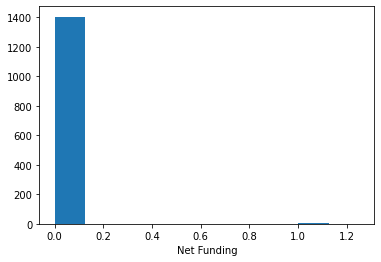

In [ ]:
plt.hist(data_summary['Total_Contribution'], bins=10, range=[0, 1.25])
plt.xlabel('Net Funding')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


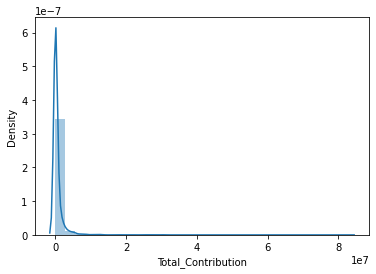

In [ ]:
sns.distplot(data_summary['Total_Contribution'], bins=30)